In [54]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, cv
import catboost
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import log_loss

In [13]:
!pip install xgboost
!pip install lightgbm
!pip install catboost

     ---------------------------------------- 99.7/99.7 MB 6.2 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 5.2 MB/s eta 0:00:00
     -------------------------------------- 101.0/101.0 MB 5.6 MB/s eta 0:00:00
     ---------------------------------------- 47.0/47.0 kB 1.2 MB/s eta 0:00:00


Dataset Info.

1. train.csv

train 데이터 : 2019년 01월 01일부터 2023년 03월 03일까지의 유통된 품목의 가격 데이터
item: 품목 코드
TG : 감귤
BC : 브로콜리
RD : 무
CR : 당근
CB : 양배추
corporation : 유통 법인 코드
법인 A부터 F 존재
location : 지역 코드
J : 제주도 제주시
S : 제주도 서귀포시
supply(kg) : 유통된 물량, kg 단위
price(원/kg) : 유통된 품목들의 kg 마다의 가격, 원 단위


2. international_trade.csv

관련 품목 수출입 정보
중량 단위 kg
금액 단위 천 달러


3. test.csv

test 데이터 : 2023년 03월 04일부터 2023년 03월 31일까지의 데이터


4. sample_submission.csv

제출을 위한 양식
2023년 03월 04일부터 2023년 03월 31일까지의 price(원/kg)을 예측
ID는 품목, 유통 법인, 지역 코드로 구성된 식별자
해당 ID에 맞춰 price(원/kg) 예측값을 answer 컬럼에 기입해야 함

In [5]:
os.getcwd()

'C:\\Users\\jjy45\\Downloads'

In [6]:
directory = 'C:/Users/jjy45/OneDrive/바탕 화면/open'
os.chdir(directory)

In [7]:
os.getcwd()

'C:\\Users\\jjy45\\OneDrive\\바탕 화면\\open'

## 데이터 불러오기

In [67]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
trade = pd.read_csv('international_trade.csv')

In [68]:
train.head()   #날짜데이터 2019-01-01 ~ 2023-03-03 

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0


In [69]:
train.tail()

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0
59396,RD_F_J_20230303,2023-03-03,RD,F,J,427520.0,529.0


In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           59397 non-null  object 
 1   timestamp    59397 non-null  object 
 2   item         59397 non-null  object 
 3   corporation  59397 non-null  object 
 4   location     59397 non-null  object 
 5   supply(kg)   59397 non-null  float64
 6   price(원/kg)  59397 non-null  float64
dtypes: float64(2), object(5)
memory usage: 3.2+ MB


In [71]:
# 'date'를 제외한 컬럼 저장하기
# 'timestamp' 컬럼을 datetime 타입으로 변경
train['timestamp'] = pd.to_datetime(train['timestamp'])
test['timestamp'] = pd.to_datetime(test['timestamp'])

train.head()

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg)
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0


In [72]:
# 날짜 관련 feature 추가 하기

train['year'] = train['timestamp'].dt.year
train['month'] = train['timestamp'].dt.month
train['week'] = train['timestamp'].dt.isocalendar().week.astype(np.int32)
train['weekday']  = train['timestamp'].dt.weekday

# 날짜 관련 피처를 저장해 둔다.
features_date = ['month', 'week', 'weekday']

In [73]:
train['item'].value_counts()

TG    15230
BC    13707
RD    12184
CR    10661
CB     7615
Name: item, dtype: int64

In [74]:
train.isna().sum()

ID             0
timestamp      0
item           0
corporation    0
location       0
supply(kg)     0
price(원/kg)    0
year           0
month          0
week           0
weekday        0
dtype: int64

In [75]:
train.describe()

,supply(kg),price(원/kg),year,month,week,weekday
count,5.939700e+04,59397.000000,59397.000000,59397.000000,59397.000000,59397.000000
mean,1.189453e+04,1131.680674,2020.601445,6.320420,25.772160,2.998687
std,5.226400e+04,2029.941445,1.201092,3.519942,15.382153,1.998374
min,0.000000e+00,0.000000,2019.000000,1.000000,1.000000,0.000000
25%,0.000000e+00,0.000000,2020.000000,3.000000,12.000000,1.000000
50%,0.000000e+00,0.000000,2021.000000,6.000000,26.000000,3.000000
75%,3.800000e+03,1519.000000,2022.000000,9.000000,39.000000,5.000000
max,1.222800e+06,20909.000000,2023.000000,12.000000,53.000000,6.000000


In [76]:
# 컬럼명 변경
train = train.rename(columns = {'price(원/kg)' : 'price', 'supply(kg)' : 'supply'})
train

,ID,timestamp,item,corporation,location,supply,price,year,month,week,weekday
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,1,2
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,1,3
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,1,4
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,2023,2,9,0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,2023,2,9,1
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,2023,3,9,2
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,2023,3,9,3


## 데이터 시각화

In [77]:
print(train.price.describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1]))

count    59397.000000
mean      1131.680674
std       2029.941445
min          0.000000
25%          0.000000
50%          0.000000
75%       1519.000000
85%       2748.600000
90%       4219.000000
100%     20909.000000
max      20909.000000
Name: price, dtype: float64


C:\Users\jjy45\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


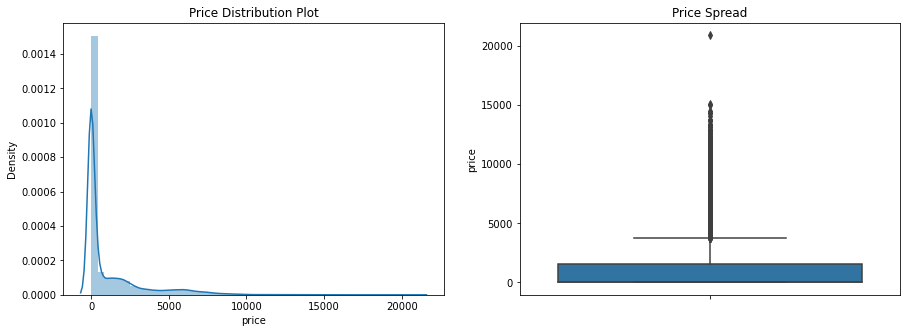

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Price Distribution Plot')
sns.distplot(train.price)

plt.subplot(1,2,2)
plt.title('Price Spread')
sns.boxplot(y=train.price)

plt.show()


품목 분할 x price 분포

C:\Users\jjy45\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jjy45\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jjy45\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

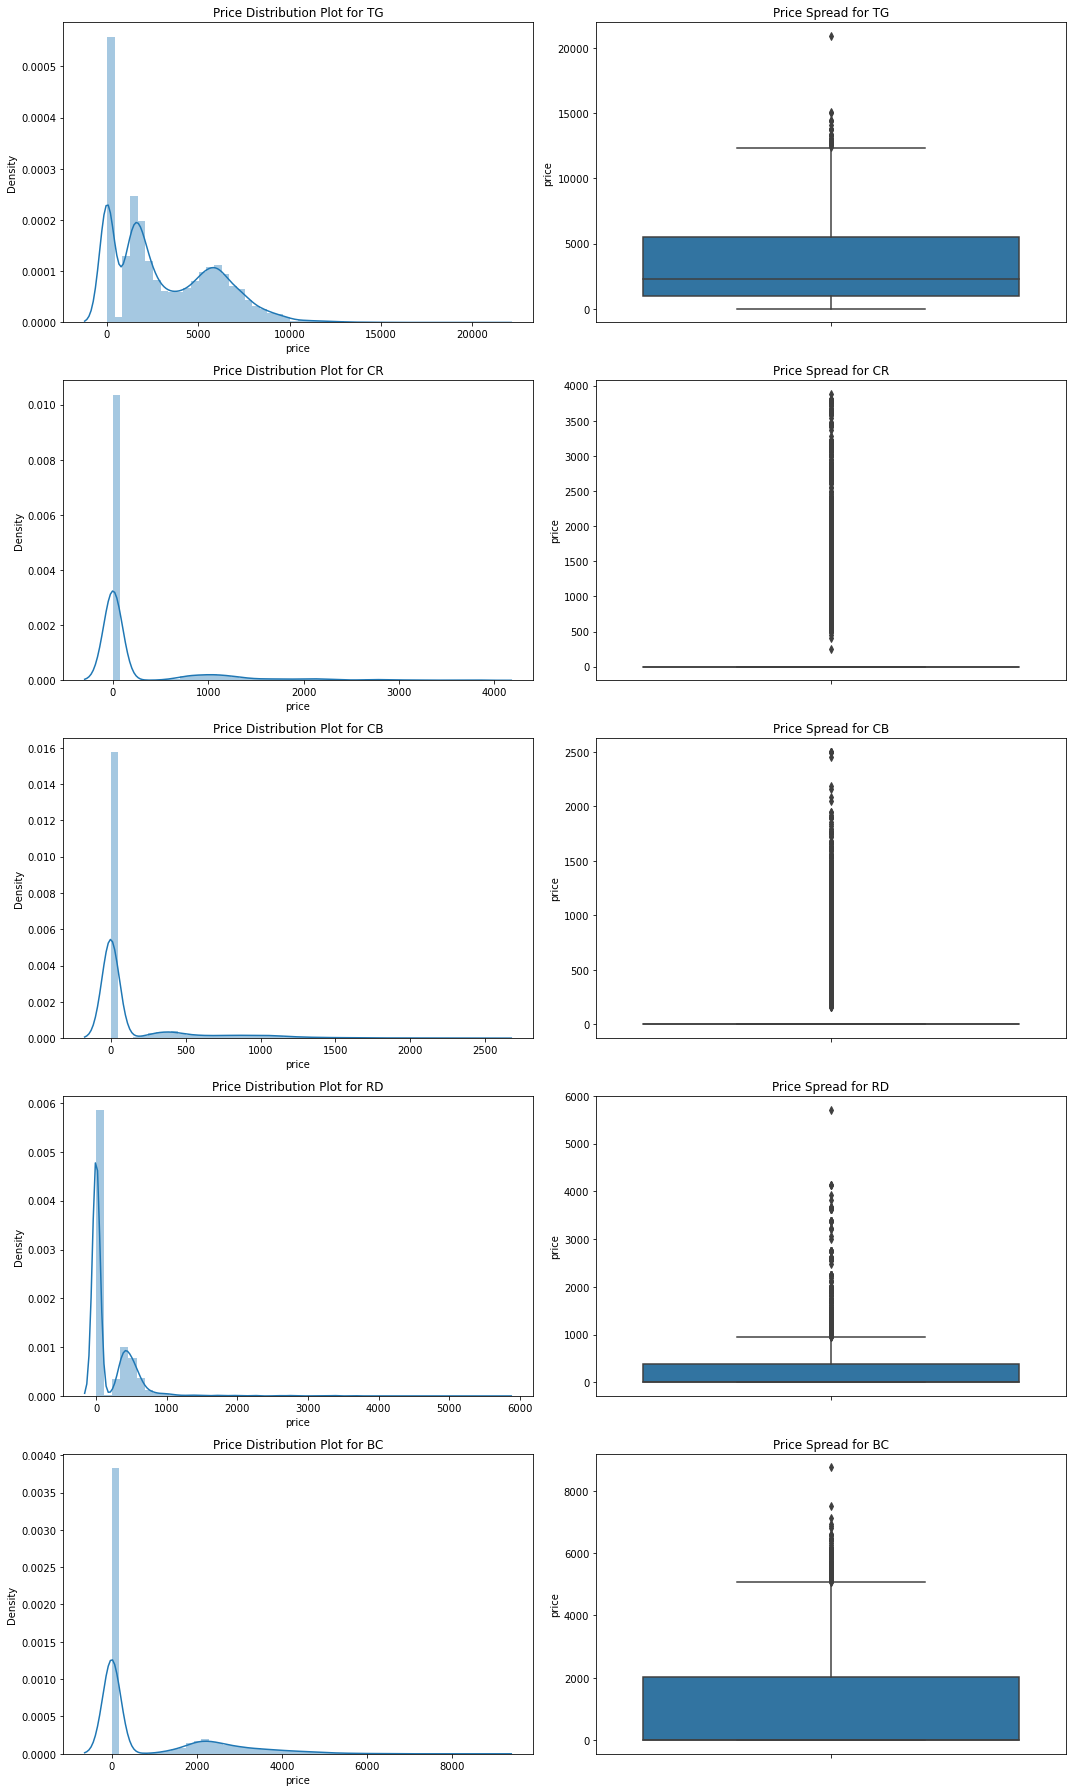

In [79]:
# train 데이터에서 각 품목별로 분할
items = train['item'].unique()

plt.figure(figsize=(15, 5 * len(items)))

for i, item in enumerate(items, 1):
    plt.subplot(len(items), 2, 2 * i - 1)
    plt.title(f'Price Distribution Plot for {item}')
    sns.distplot(train[train['item'] == item]['price'])
    
    plt.subplot(len(items), 2, 2 * i)
    plt.title(f'Price Spread for {item}')
    sns.boxplot(y=train[train['item'] == item]['price'])

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='item', ylabel='price'>

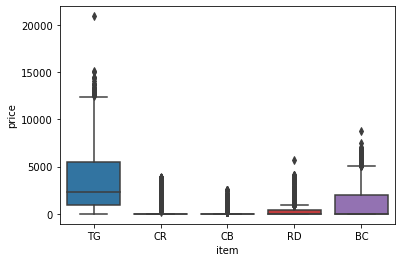

In [80]:
sns.boxplot(x='item',y='price',data=train)

<AxesSubplot:xlabel='corporation', ylabel='price'>

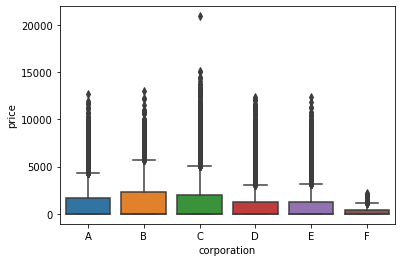

In [81]:
sns.boxplot(x='corporation',y='price',data=train)

<AxesSubplot:xlabel='location', ylabel='price'>

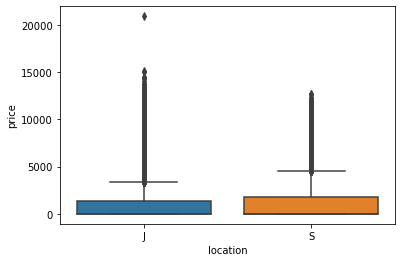

In [82]:
sns.boxplot(x='location',y='price',data=train)

<AxesSubplot:xlabel='supply', ylabel='price'>

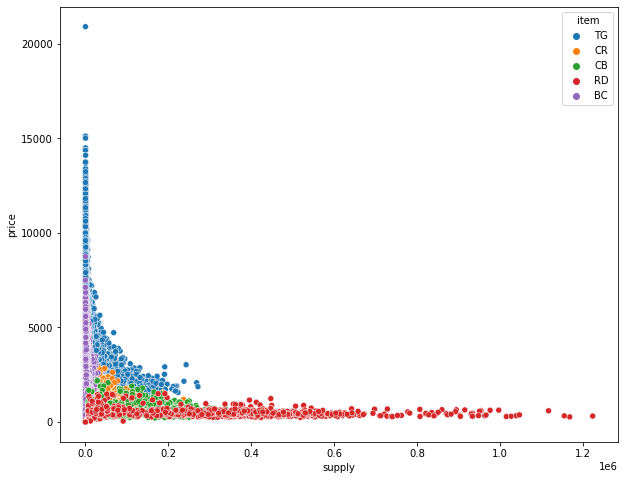

In [83]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=train,x ='supply',y='price',hue='item')

In [84]:
train.groupby('item')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
item,,,,,,,,
BC,13707.0,910.196615,1422.148301,0.0,0.00,0.0,2032.50,8750.0
CB,7615.0,152.187131,345.053036,0.0,0.00,0.0,0.00,2500.0
CR,10661.0,273.118938,632.929933,0.0,0.00,0.0,0.00,3882.0
RD,12184.0,187.073539,358.150266,0.0,0.00,0.0,383.00,5715.0
TG,15230.0,3177.442022,2805.240092,0.0,992.25,2273.5,5532.75,20909.0


In [85]:
train.groupby('item')['price'].sum()

item
BC    12476065.0
CB     1158905.0
CR     2911721.0
RD     2279304.0
TG    48392442.0
Name: price, dtype: float64

<AxesSubplot:xlabel='supply', ylabel='price'>

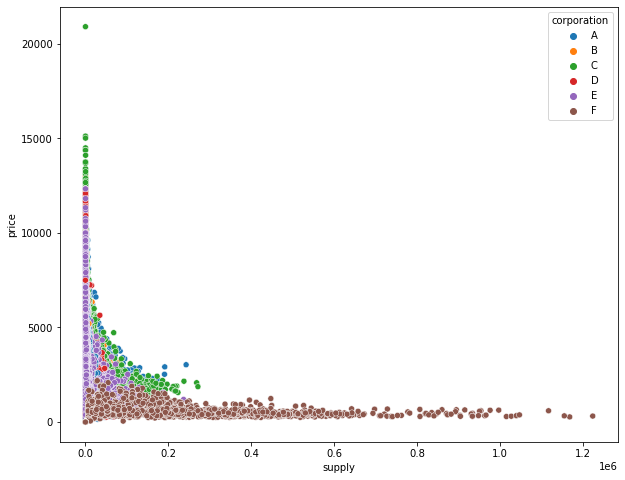

In [86]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=train,x ='supply',y='price',hue='corporation')

In [87]:
train.groupby('corporation')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
corporation,,,,,,,,
A,13707.0,1141.704458,1963.913065,0.0,0.0,0.0,1712.00,12665.0
B,7615.0,1544.736179,2344.967575,0.0,0.0,0.0,2288.00,13000.0
C,9138.0,1468.417159,2525.616068,0.0,0.0,0.0,2012.00,20909.0
D,12184.0,1025.189511,1917.189163,0.0,0.0,0.0,1232.25,12333.0
E,13707.0,956.251404,1737.371106,0.0,0.0,0.0,1254.50,12333.0
F,3046.0,259.121799,348.402146,0.0,0.0,0.0,447.00,2189.0


In [88]:
train.groupby('corporation')['price'].sum()

corporation
A    15649343.0
B    11763166.0
C    13418396.0
D    12490909.0
E    13107338.0
F      789285.0
Name: price, dtype: float64

<AxesSubplot:xlabel='supply', ylabel='price'>

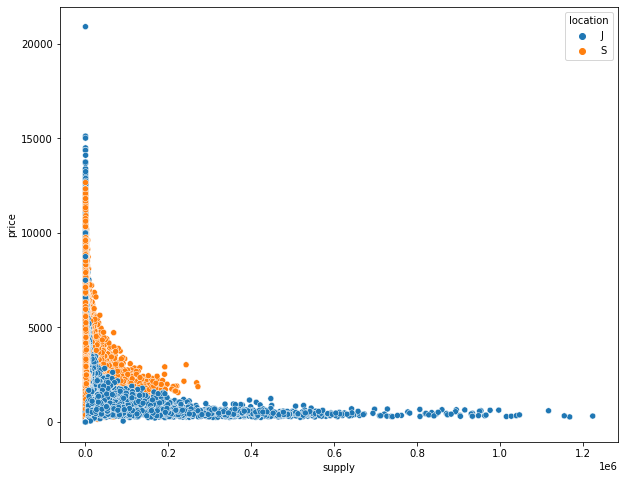

In [89]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=train,x ='supply',y='price',hue='location')

In [90]:
train.groupby('location')['price'].sum()

location
J    37213110.0
S    30005327.0
Name: price, dtype: float64

In [91]:
train.groupby('location')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
J,35029.0,1062.35148,1959.096959,0.0,0.0,0.0,1344.0,20909.0
S,24368.0,1231.34139,2123.731052,0.0,0.0,0.0,1823.0,12667.0


In [92]:
train[['supply','price']].corr()

,supply,price
supply,1.000000,-0.002297
price,-0.002297,1.000000


<AxesSubplot:xlabel='month', ylabel='price'>

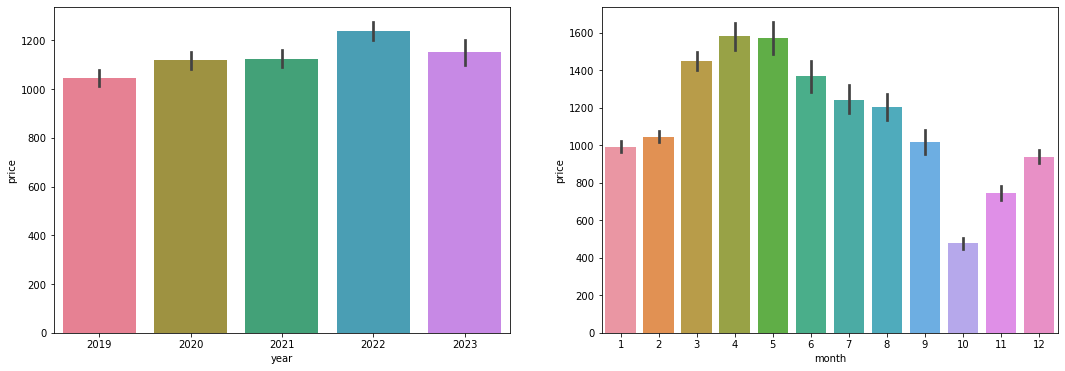

In [93]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(data=train,x='year',y='price',ax=axes[0],palette='husl')
sns.barplot(data=train,x='month',y='price',ax=axes[1])


<AxesSubplot:xlabel='weekday', ylabel='price'>

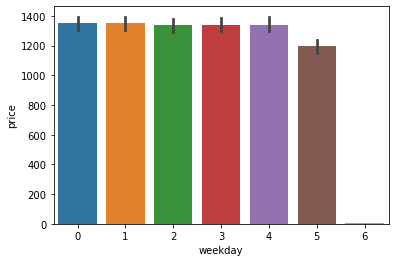

In [94]:
plt.figure(figsize=(6,4))
sns.barplot(data=train,x='weekday',y='price') #0부터 월~일

### 품목별 연/월 가격 barplot

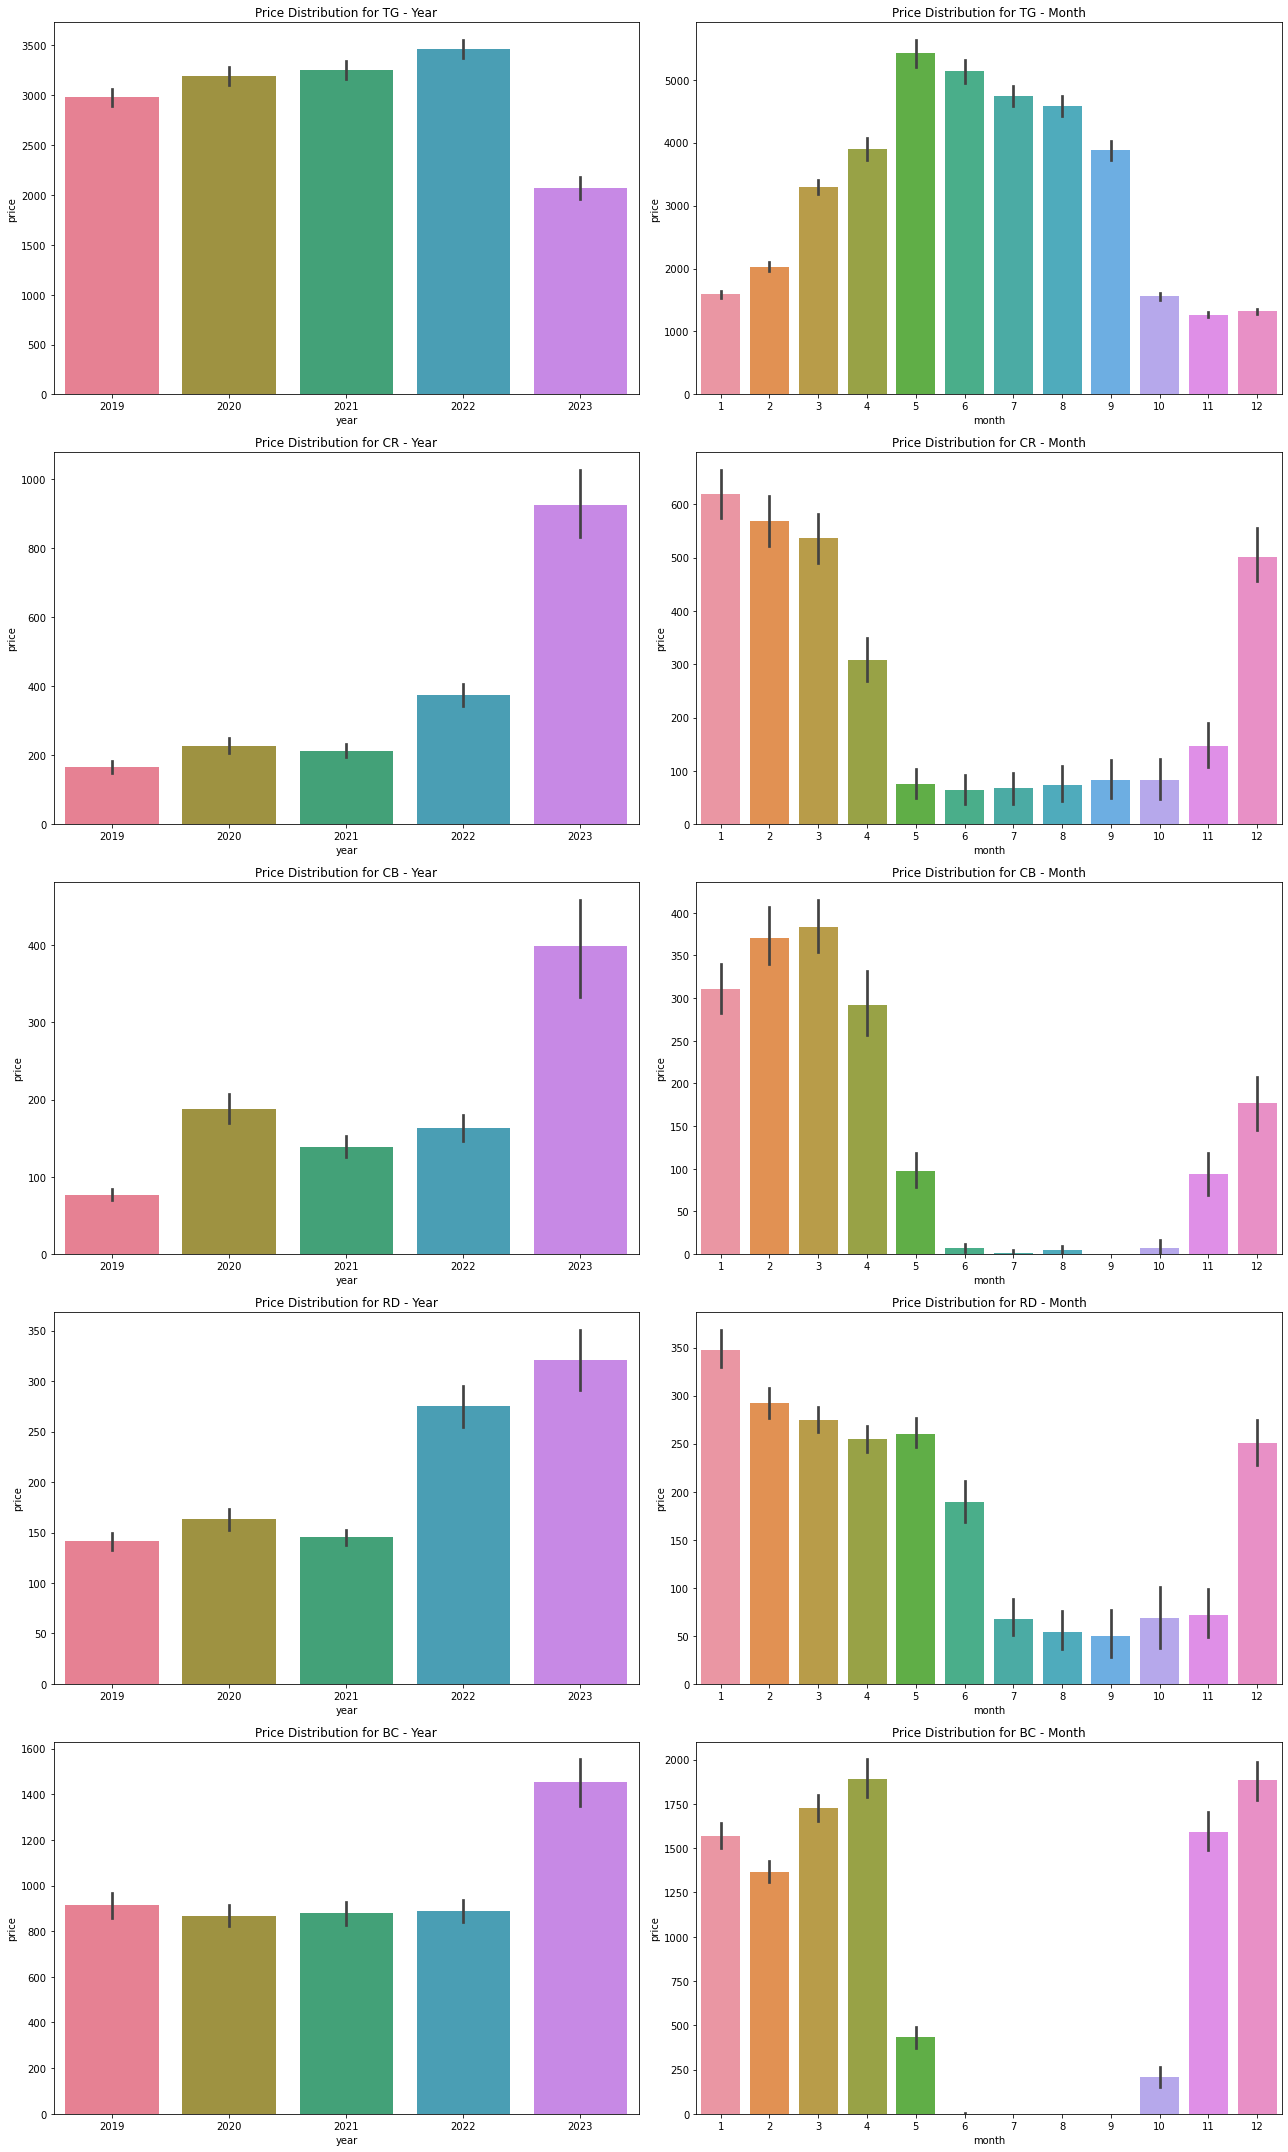

In [95]:
# train 데이터에서 각 품목별로 분할
items = train['item'].unique()

# 서브플롯의 개수 설정
num_subplots = len(items)

# 전체 그림 크기 설정
fig, axes = plt.subplots(num_subplots, 2, figsize=(18, 6 * num_subplots))

# 각 품목에 대한 시각화
for i, item in enumerate(items):
    # 해당 품목의 데이터 추출
    item_data = train[train['item'] == item]

    # 첫 번째 서브플롯: 연도별 가격
    sns.barplot(data=item_data, x='year', y='price', ax=axes[i][0], palette='husl')
    axes[i][0].set_title(f'Price Distribution for {item} - Year')

    # 두 번째 서브플롯: 월별 가격
    sns.barplot(data=item_data, x='month', y='price', ax=axes[i][1])
    axes[i][1].set_title(f'Price Distribution for {item} - Month')

# 레이아웃 조정
plt.tight_layout()
plt.show()


### 품목별 요일 barplot

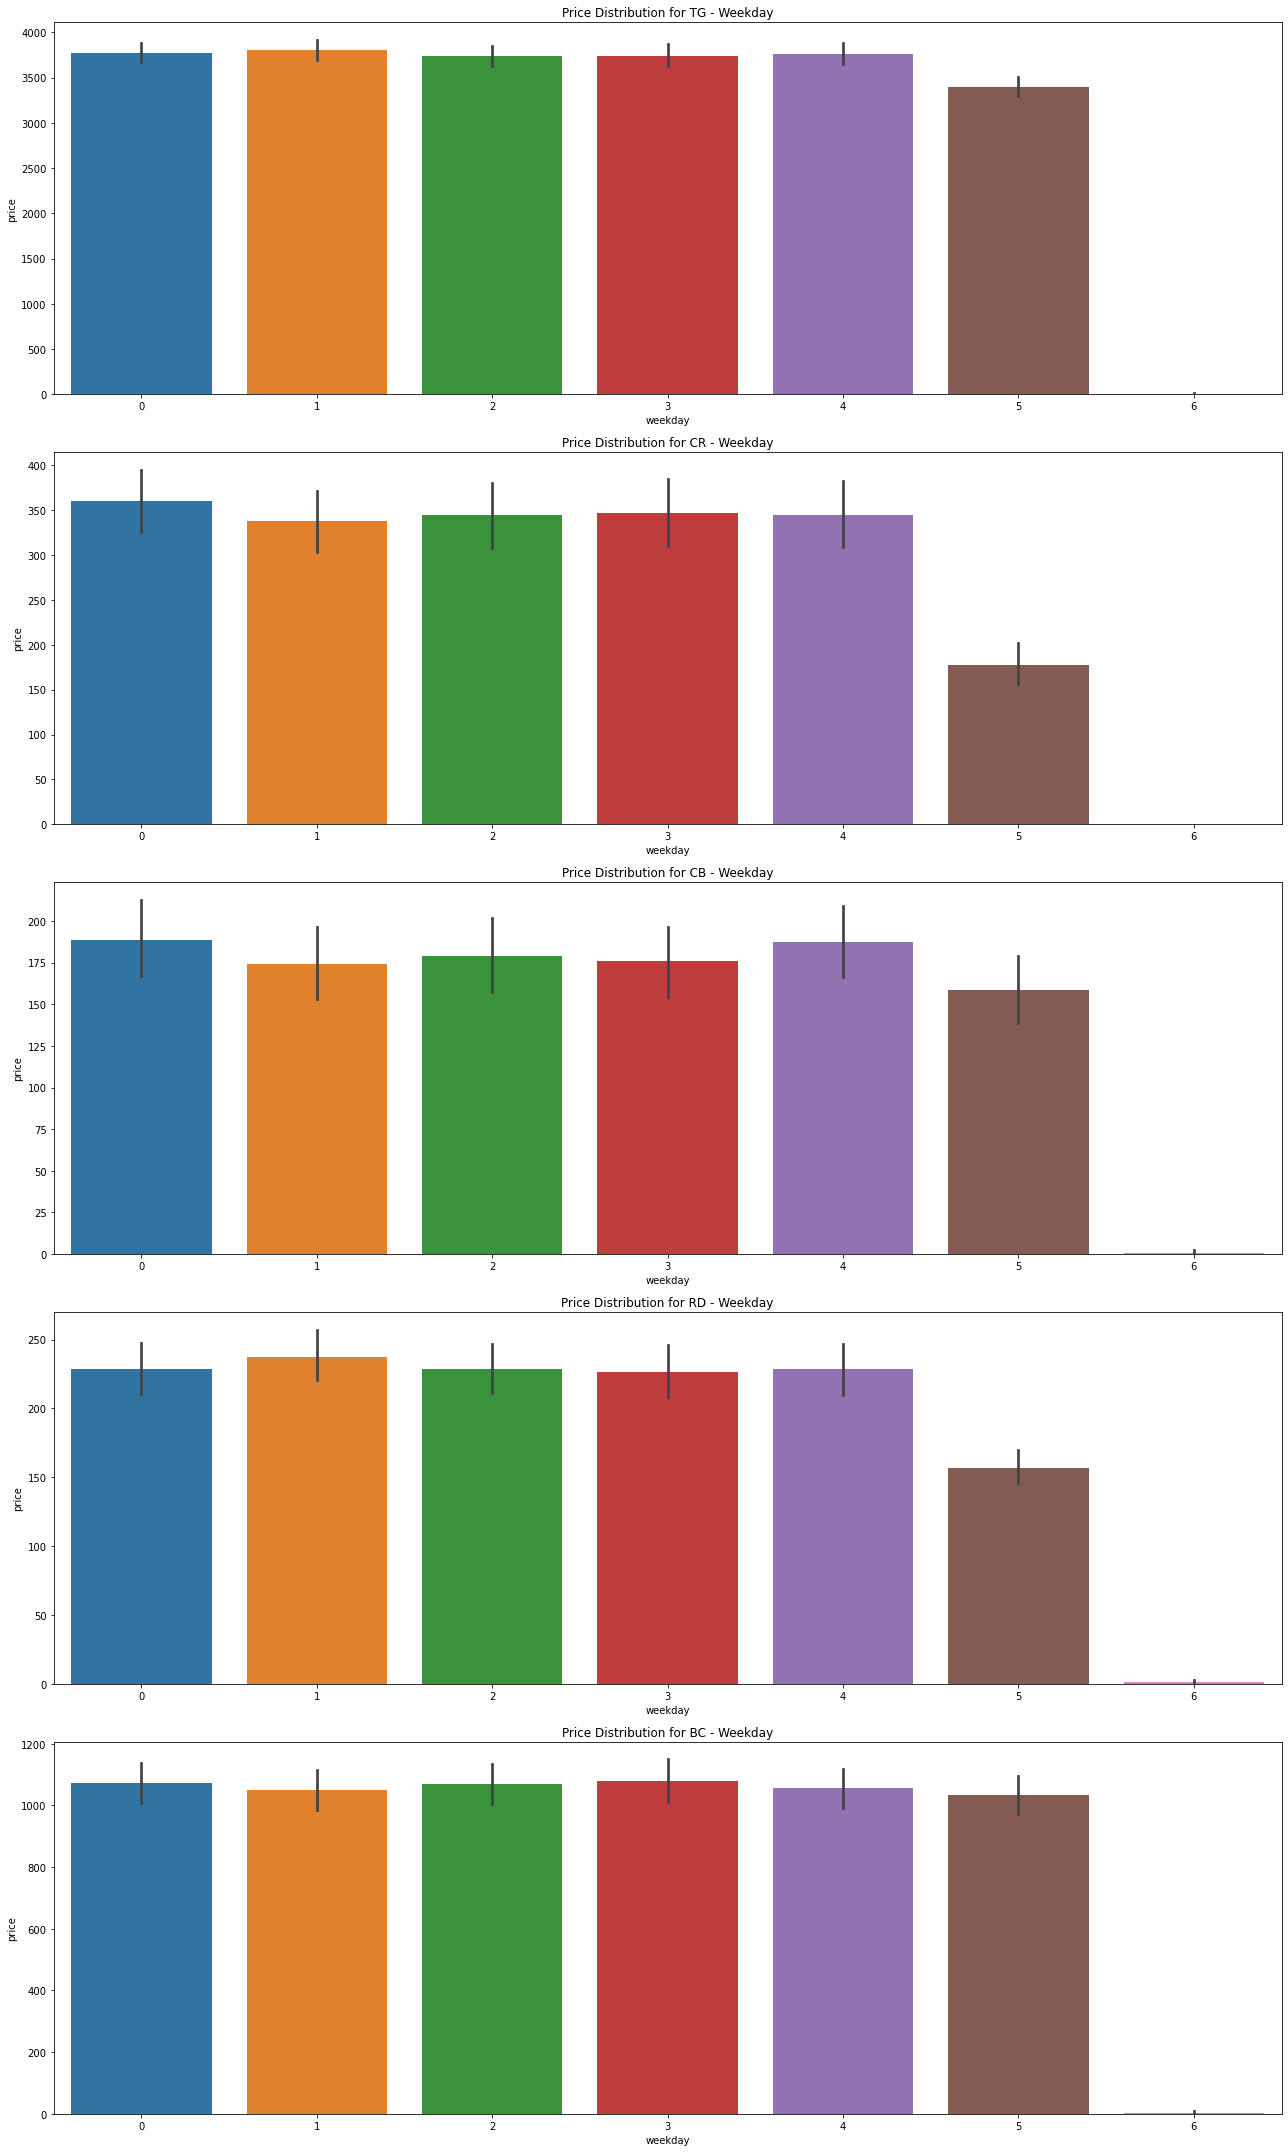

In [96]:
# train 데이터에서 각 품목별로 분할
items = train['item'].unique()

plt.figure(figsize=(18, 6 * len(items)))

# 각 품목에 대한 시각화
for i, item in enumerate(items, 1):
    plt.subplot(len(items), 1, i)
    plt.title(f'Price Distribution for {item} - Weekday')
    item_data = train[train['item'] == item]
    sns.barplot(data=item_data, x='weekday', y='price')

# 레이아웃 조정
plt.tight_layout()
plt.show()

In [97]:
### EDA 예시 봤는데 supply 0 넣은거랑 뺸거랑 별 차이가 없다고 하긴 함...
### 그리고 휴일 여부에 따라서 차이가 있어서 해바야 할 듯!!

In [98]:
train['item'].value_counts()

TG    15230
BC    13707
RD    12184
CR    10661
CB     7615
Name: item, dtype: int64

In [99]:
items = train['item'].value_counts().index.to_list()
items

['TG', 'BC', 'RD', 'CR', 'CB']

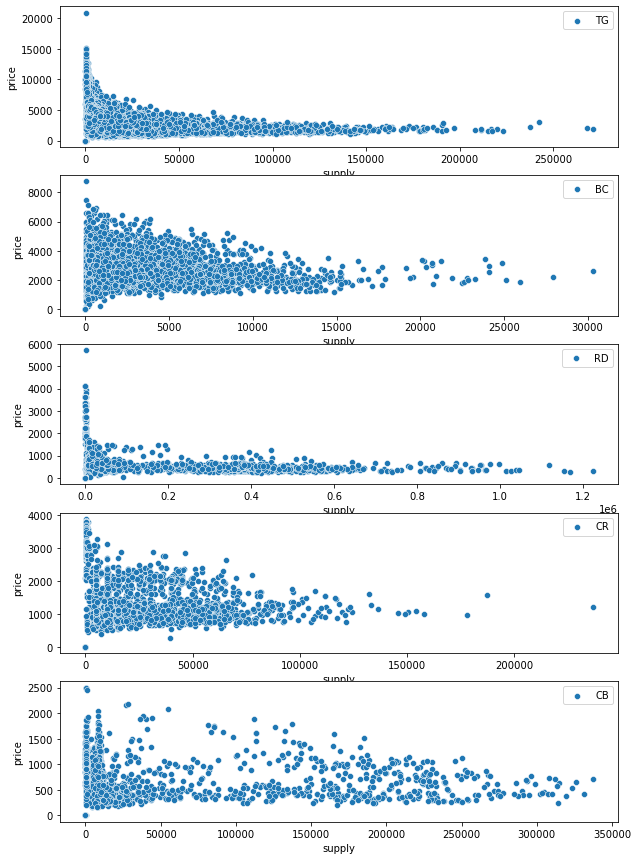

In [100]:
fig, axes = plt.subplots(5,1,figsize=(10,15))
for i in range(len(items)):
    r = i%5
    sns.scatterplot(data = train[train['item']==items[i]], x = 'supply',y='price',ax=axes[r],label=items[i])

In [101]:
corp = train['corporation'].value_counts().index.to_list()
corp

['A', 'E', 'D', 'C', 'B', 'F']

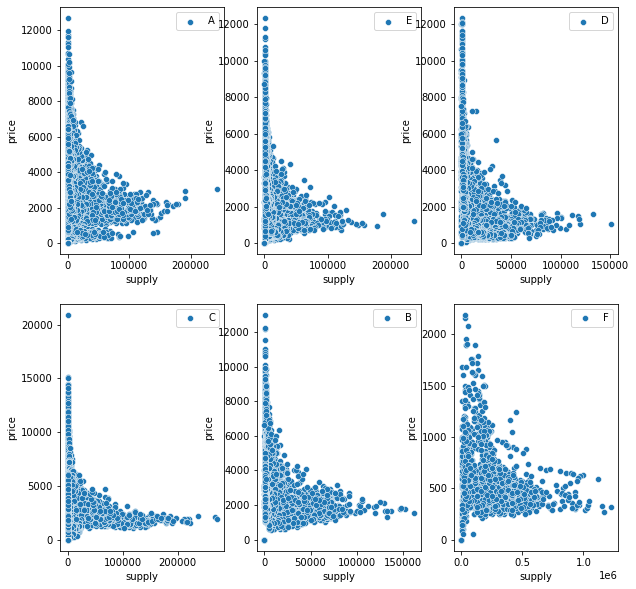

In [102]:
fig, axes = plt.subplots(2,3,figsize=(10,10))
for i in range(len(corp)):
    n=int(i/3)
    r = i%3
    sns.scatterplot(data = train[train['corporation']==corp[i]], x = 'supply',y='price',ax=axes[n][r],label=corp[i])

In [103]:
loc = train['location'].value_counts().index.to_list()
loc

['J', 'S']

<AxesSubplot:xlabel='supply', ylabel='price'>

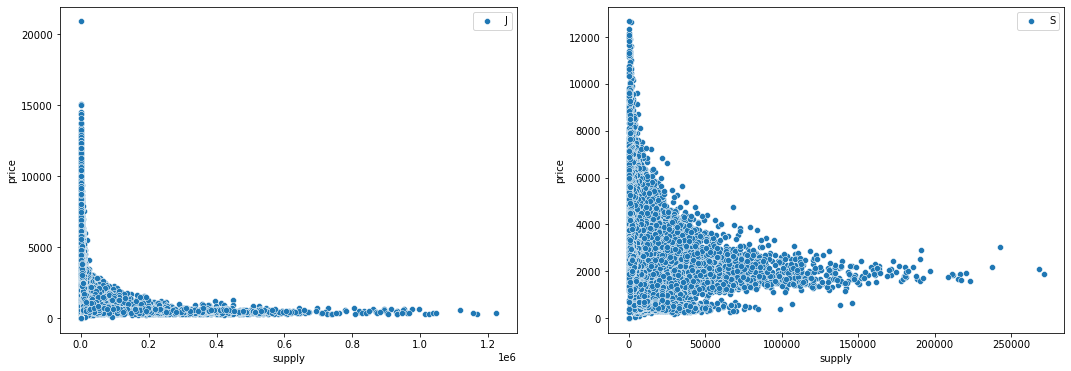

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.scatterplot(data = train[train['location']==loc[0]], x = 'supply',y='price',label=loc[0],ax = axes[0])
sns.scatterplot(data = train[train['location']==loc[1]], x = 'supply',y='price',label=loc[1],ax = axes[1])

### supply 0 인 경우 제외 => not_zero로 설정

In [105]:
len(train), len(train[train['supply']==0])

(59397, 35452)

In [137]:
not_zero = train[train['supply']!=0]
not_zero

,ID,timestamp,item,corporation,location,supply,price,year,month,week,weekday,holiday
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,1,3,0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,1,4,0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,1,5,1
6,TG_A_J_20190107,2019-01-07,TG,A,J,44995.0,1474.0,2019,1,2,0,0
7,TG_A_J_20190108,2019-01-08,TG,A,J,26975.0,1326.0,2019,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,2023,2,9,0,0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,2023,2,9,1,0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,2023,3,9,2,1
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,2023,3,9,3,0


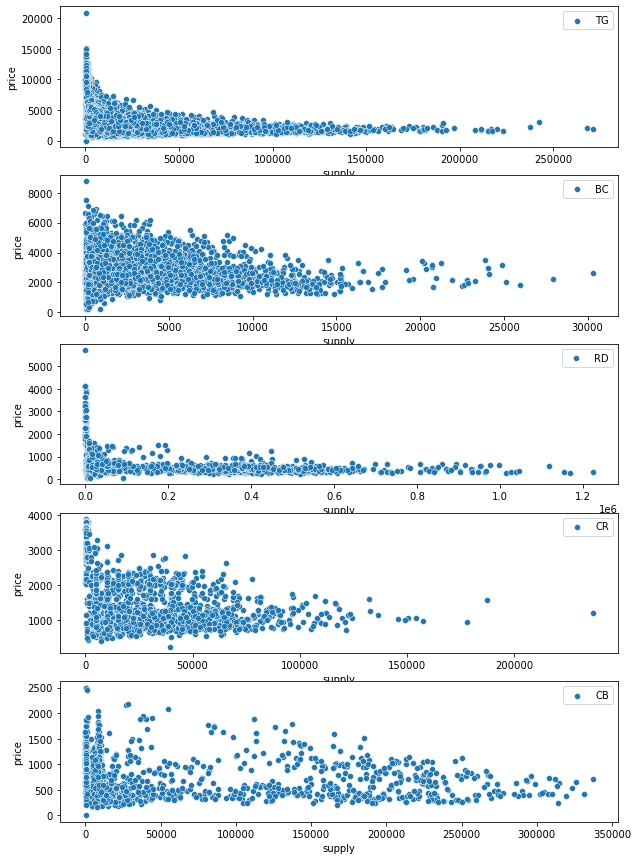

In [138]:
fig, axes = plt.subplots(5,1,figsize=(10,15))
for i in range(len(items)):
    r = i%5
    sns.scatterplot(data = not_zero[not_zero['item']==items[i]], x = 'supply',y='price',ax=axes[r],label=items[i])

In [139]:
not_zero['item'].value_counts()

TG    11677
BC     4525
RD     4040
CR     2082
CB     1621
Name: item, dtype: int64

##### 연도,월 컬럼 만들기

In [140]:
not_zero['y-m']=not_zero['timestamp'].dt.strftime('%Y-%m')
not_zero['y-m']

2        2019-01
3        2019-01
4        2019-01
6        2019-01
7        2019-01
          ...   
59392    2023-02
59393    2023-02
59394    2023-03
59395    2023-03
59396    2023-03
Name: y-m, Length: 23945, dtype: object

### 시계열 시각화

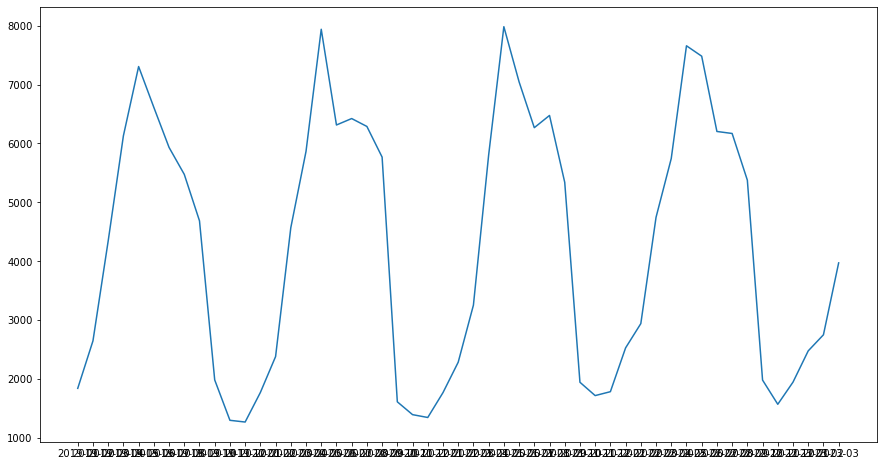

In [195]:
plt.figure(figsize=(15,8))
plt.plot(not_zero[not_zero['item'] == 'TG'].groupby(['y-m'])['price'].mean())

In [219]:
#시계열 분석을 해볼게여

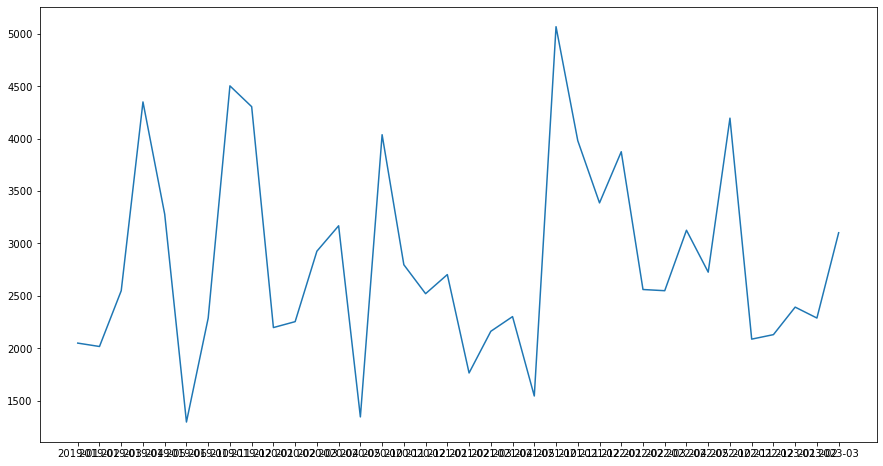

In [196]:
plt.figure(figsize=(15,8))
plt.plot(not_zero[not_zero['item'] == 'BC'].groupby(['y-m'])['price'].mean())

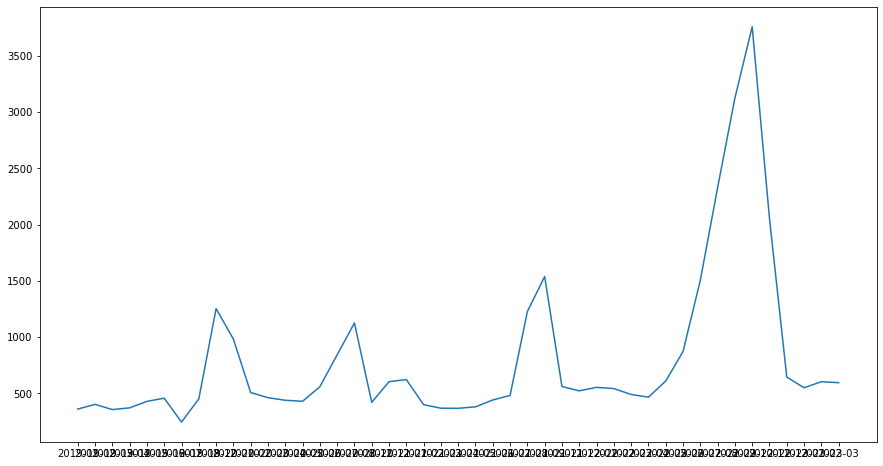

In [197]:
plt.figure(figsize=(15,8))
plt.plot(not_zero[not_zero['item'] == 'RD'].groupby(['y-m'])['price'].mean())

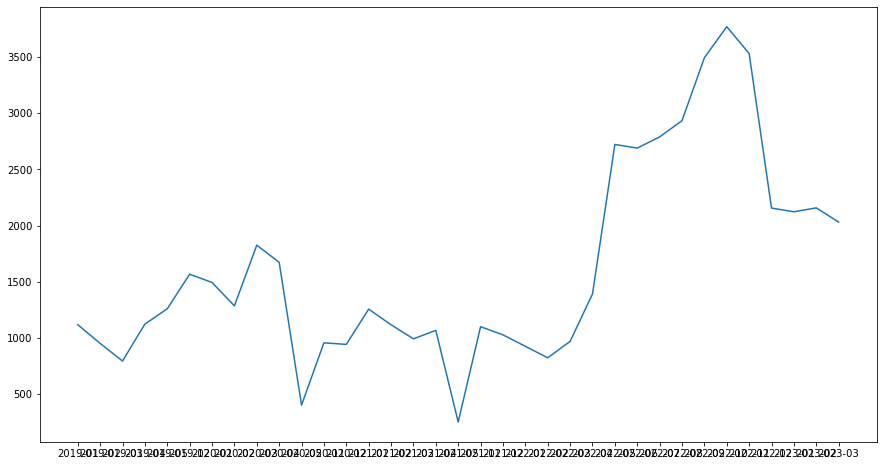

In [198]:
plt.figure(figsize=(15,8))
plt.plot(not_zero[not_zero['item'] == 'CR'].groupby(['y-m'])['price'].mean())

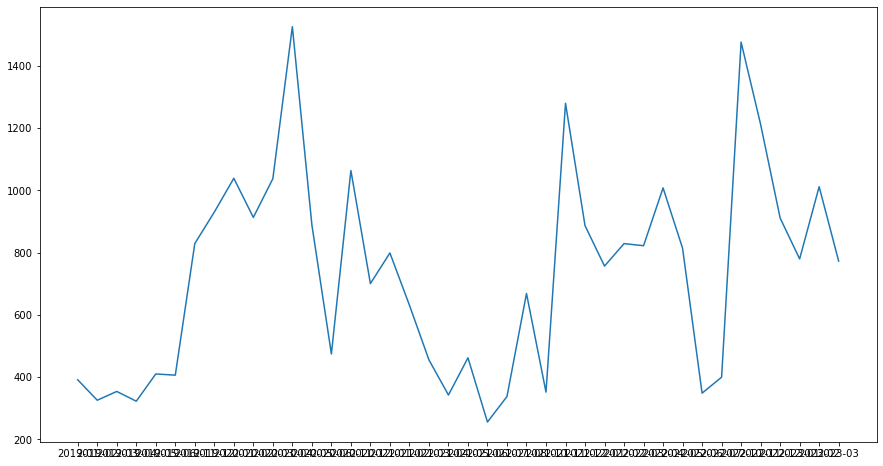

In [199]:
plt.figure(figsize=(15,8))
plt.plot(not_zero[not_zero['item'] == 'CB'].groupby(['y-m'])['price'].mean())

#### spply 0 제외와 all의 히트맵 비교

Text(0.5, 1.0, 'all')

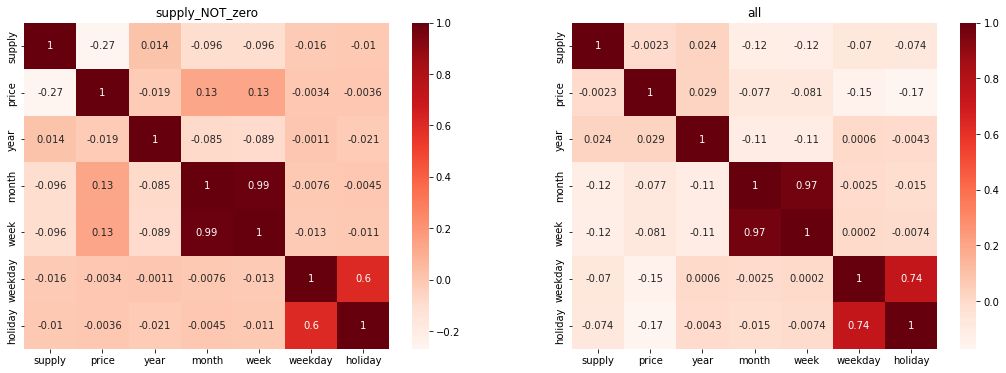

In [142]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.heatmap(not_zero.corr(),annot=True,cmap='Reds',ax = axes[0])
axes[0].set_title('supply_NOT_zero')
sns.heatmap(train.corr(),annot=True,cmap='Reds',ax = axes[1])
axes[1].set_title('all')

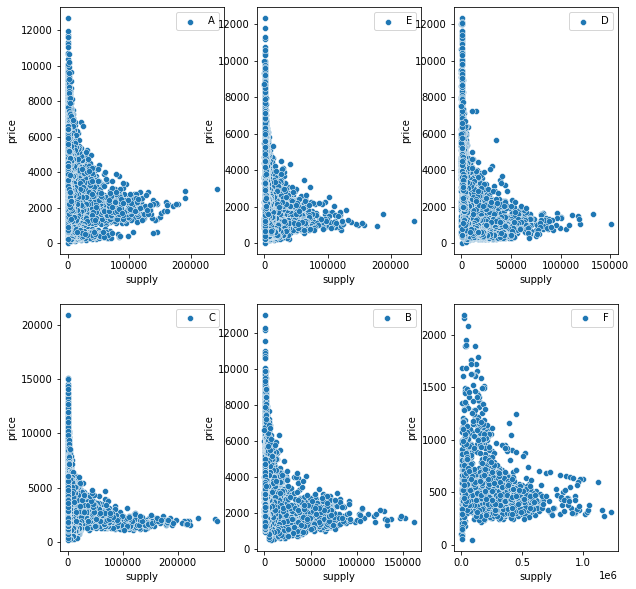

In [143]:
fig, axes = plt.subplots(2,3,figsize=(10,10))
for i in range(len(corp)):
    n=int(i/3)
    r = i%3
    sns.scatterplot(data = not_zero[not_zero['corporation']==corp[i]], x = 'supply',y='price',ax=axes[n][r],label=corp[i])

In [149]:
#요건 별 차이 없음

<AxesSubplot:xlabel='month', ylabel='price'>

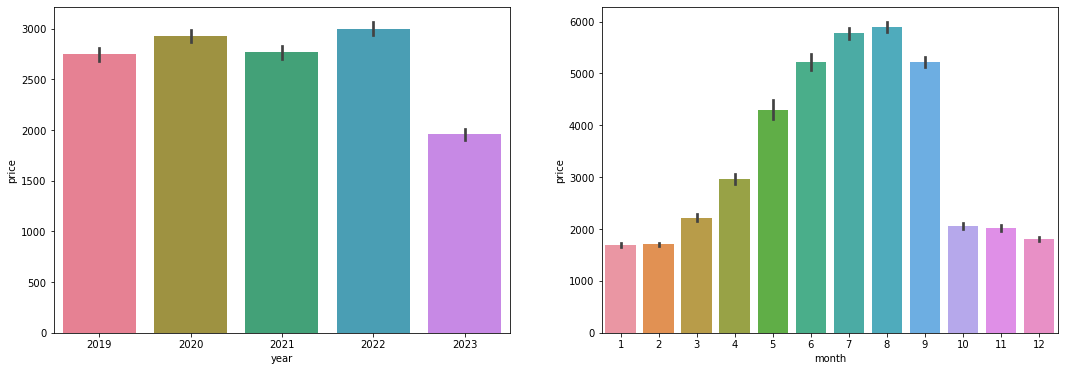

In [144]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.barplot(data=not_zero,x='year',y='price',ax=axes[0],palette='husl')
sns.barplot(data=not_zero,x='month',y='price',ax=axes[1])

In [150]:
#요건 차이가 좀 있다..?

### 휴일여부

In [125]:
from pytimekr import pytimekr

In [124]:
!pip install pytimekr

  Created wheel for pytimekr: filename=pytimekr-0.1.0-py3-none-any.whl size=7941 sha256=d89d8203ed39614db24f8c5695e94c06f8add1c8ed1772435f0dc82fd88486af
  Stored in directory: c:\users\jjy45\appdata\local\pip\cache\wheels\b3\4c\d7\3347f605b50476d8c60c0e11fb7ffcb473446b1ec013e01d81
Successfully built pytimekr


In [145]:
#주말 또는 공휴일이면 1반환 코드

year_2019 = pytimekr.holidays(year=2019)
year_2020 = pytimekr.holidays(year=2020)
year_2021 = pytimekr.holidays(year=2021)
year_2022 = pytimekr.holidays(year=2022)
year_2023 = pytimekr.holidays(year=2023)



def holidays(x):
    if x.weekday() in range(5,8):
        return 1
    if x.year == 2019  and x in year_2019 :
        return 1 
    elif x.year == 2020 and x in year_2020:
        return 1 
    elif x.year == 2021 and x in year_2021 :
        return 1 
    elif x.year == 2022 and x in year_2022 :
        return 1
    elif x.year == 2023 and x in year_2023:
        return 1
    else:
        return 0

In [146]:
import warnings
warnings.filterwarnings('ignore')
train['holiday'] = train['timestamp'].apply(holidays)
train

,ID,timestamp,item,corporation,location,supply,price,year,month,week,weekday,holiday
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,1,2,0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,1,3,0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,1,4,0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,2023,2,9,0,0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,2023,2,9,1,0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,2023,3,9,2,1
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,2023,3,9,3,0


In [147]:
train['holiday'].value_counts()

0    40872
1    18525
Name: holiday, dtype: int64

<AxesSubplot:xlabel='location', ylabel='price'>

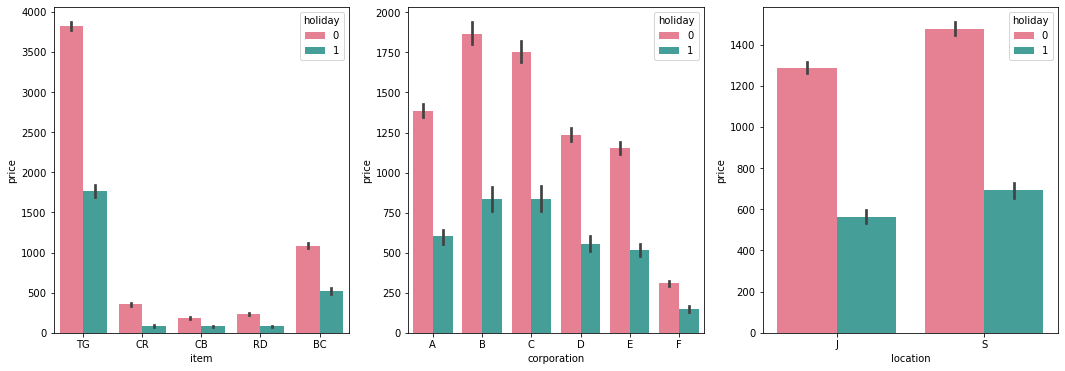

In [148]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(data=train,x='item',y='price',hue='holiday',ax=axes[0],palette='husl')
sns.barplot(data=train,x='corporation',y='price',hue='holiday',ax=axes[1],palette='husl')
sns.barplot(data=train,x='location',y='price',hue='holiday',ax=axes[2],palette='husl')

##### -> 법정 휴일이냐 아니냐에 따라 1kg에 대한 가격차이가 남

<AxesSubplot:xlabel='location', ylabel='supply'>

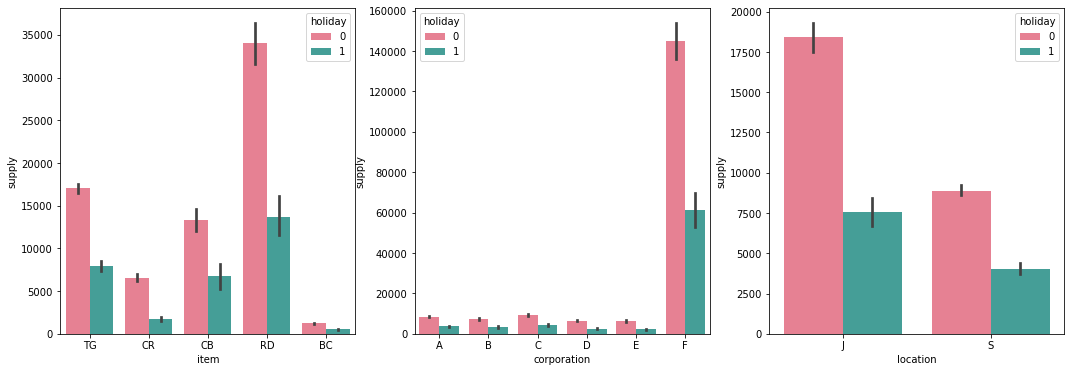

In [152]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(data=train,x='item',y='supply',hue='holiday',ax=axes[0],palette='husl')
sns.barplot(data=train,x='corporation',y='supply',hue='holiday',ax=axes[1],palette='husl')
sns.barplot(data=train,x='location',y='supply',hue='holiday',ax=axes[2],palette='husl')

##### -> 얘는 그냥 공급량도 궁금해서.. 

##### -------------------------------------------------------------------

### trade 데이터

In [174]:
trade

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38
...,...,...,...,...,...,...,...
1269,2023-02,포포(papaw)[파파야(papaya)],0,0,23830,71,-71
1270,2023-02,사과,135165,351,0,0,351
1271,2023-02,배,2206012,5411,1,0,5411
1272,2023-02,신 체리[프루너스 체라서스(Prunus cerasus)],5,0,0,0,0


In [175]:
trade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274 entries, 0 to 1273
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   기간      1274 non-null   object
 1   품목명     1274 non-null   object
 2   수출 중량   1274 non-null   int64 
 3   수출 금액   1274 non-null   int64 
 4   수입 중량   1274 non-null   int64 
 5   수입 금액   1274 non-null   int64 
 6   무역수지    1274 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 69.8+ KB


In [176]:
trade['품목명'].value_counts()

감귤                                                                               50
포포(papaw)[파파야(papaya)]                                                           50
레몬[시트러스 리몬(Citrus limon)ㆍ시트러스 리머늄(Citrus limonum)]                               50
그레이프프루트(grapefruit)와 포멜로(pomelo)                                                 50
오렌지                                                                              50
망고(mango)                                                                        50
파인애플                                                                             50
무화과                                                                              50
대추야자                                                                             50
사과                                                                               50
오이류(신선한 것이나 냉장한 것으로 한정한다)                                                        50
당근                                                                          

In [177]:
df_test = trade[trade.품목명.str.contains('감귤|브로콜리|무|당근|양배추')]
df_test

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38
5,2019-01,양배추,184650,94,395802,90,4
8,2019-01,당근,23150,22,7466150,2955,-2934
12,2019-01,무화과,2627,23,94529,464,-441
...,...,...,...,...,...,...,...
1250,2023-02,양배추,13188,13,377456,104,-91
1253,2023-02,당근,22510,20,9260020,3758,-3737
1254,2023-02,순무,4000,4,2,0,4
1258,2023-02,무화과,1319,14,104566,454,-440


In [178]:
df_test['품목명'].value_counts()

꽃양배추와 브로콜리(broccoli)    50
방울다다기 양배추               50
양배추                     50
당근                      50
무화과                     50
감귤                      50
순무                       6
Name: 품목명, dtype: int64

#### 꽃양배추와 브로콜리 -> 브로콜리, 방울다다기 양배추 -> 양배추, 순무 -> 무, 무화과 제거

In [179]:
df_test.loc[df_test['품목명']=='꽃양배추와 브로콜리(broccoli)','품목명'] = '브로콜리'
df_test.loc[df_test['품목명']=='방울다다기 양배추','품목명'] = '양배추'
df_test.loc[df_test['품목명']=='순무','품목명'] = '무'
df_test = df_test[df_test['품목명']!='무화과']
df_test

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
3,2019-01,브로콜리,160,1,638913,563,-562
4,2019-01,양배추,0,0,7580,38,-38
5,2019-01,양배추,184650,94,395802,90,4
8,2019-01,당근,23150,22,7466150,2955,-2934
17,2019-01,감귤,58368,172,0,0,172
...,...,...,...,...,...,...,...
1249,2023-02,양배추,71,1,10362,55,-55
1250,2023-02,양배추,13188,13,377456,104,-91
1253,2023-02,당근,22510,20,9260020,3758,-3737
1254,2023-02,무,4000,4,2,0,4


In [180]:
df_test['품목명'].value_counts()

양배추     100
브로콜리     50
당근       50
감귤       50
무         6
Name: 품목명, dtype: int64

In [181]:
fruits_dict = {'감귤':'TG' ,'브로콜리':'BC' ,'무':'RD' ,'당근':'CR' ,'양배추':'CB'}
fruits_dict

{'감귤': 'TG', '브로콜리': 'BC', '무': 'RD', '당근': 'CR', '양배추': 'CB'}

In [170]:
df_test['품목명'] = df_test['품목명'].map(fruits_dict)

In [184]:
df_test.reset_index()

,index,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
0,3,2019-01,BC,160,1,638913,563,-562
1,4,2019-01,CB,0,0,7580,38,-38
2,5,2019-01,CB,184650,94,395802,90,4
3,8,2019-01,CR,23150,22,7466150,2955,-2934
4,17,2019-01,TG,58368,172,0,0,172
...,...,...,...,...,...,...,...,...
251,1249,2023-02,CB,71,1,10362,55,-55
252,1250,2023-02,CB,13188,13,377456,104,-91
253,1253,2023-02,CR,22510,20,9260020,3758,-3737
254,1254,2023-02,RD,4000,4,2,0,4


In [186]:
#데이터 프레임에서 중복된 행 찾기 -> 없음
df_test[df_test.duplicated()]

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지


In [187]:
#na값 찾기 -> 없음
df_test.isna().sum()

기간       0
품목명      0
수출 중량    0
수출 금액    0
수입 중량    0
수입 금액    0
무역수지     0
dtype: int64

In [188]:
box_plot_cols = df_test.columns[2:-1]
box_plot_cols

Index(['수출 중량', '수출 금액', '수입 중량', '수입 금액'], dtype='object')

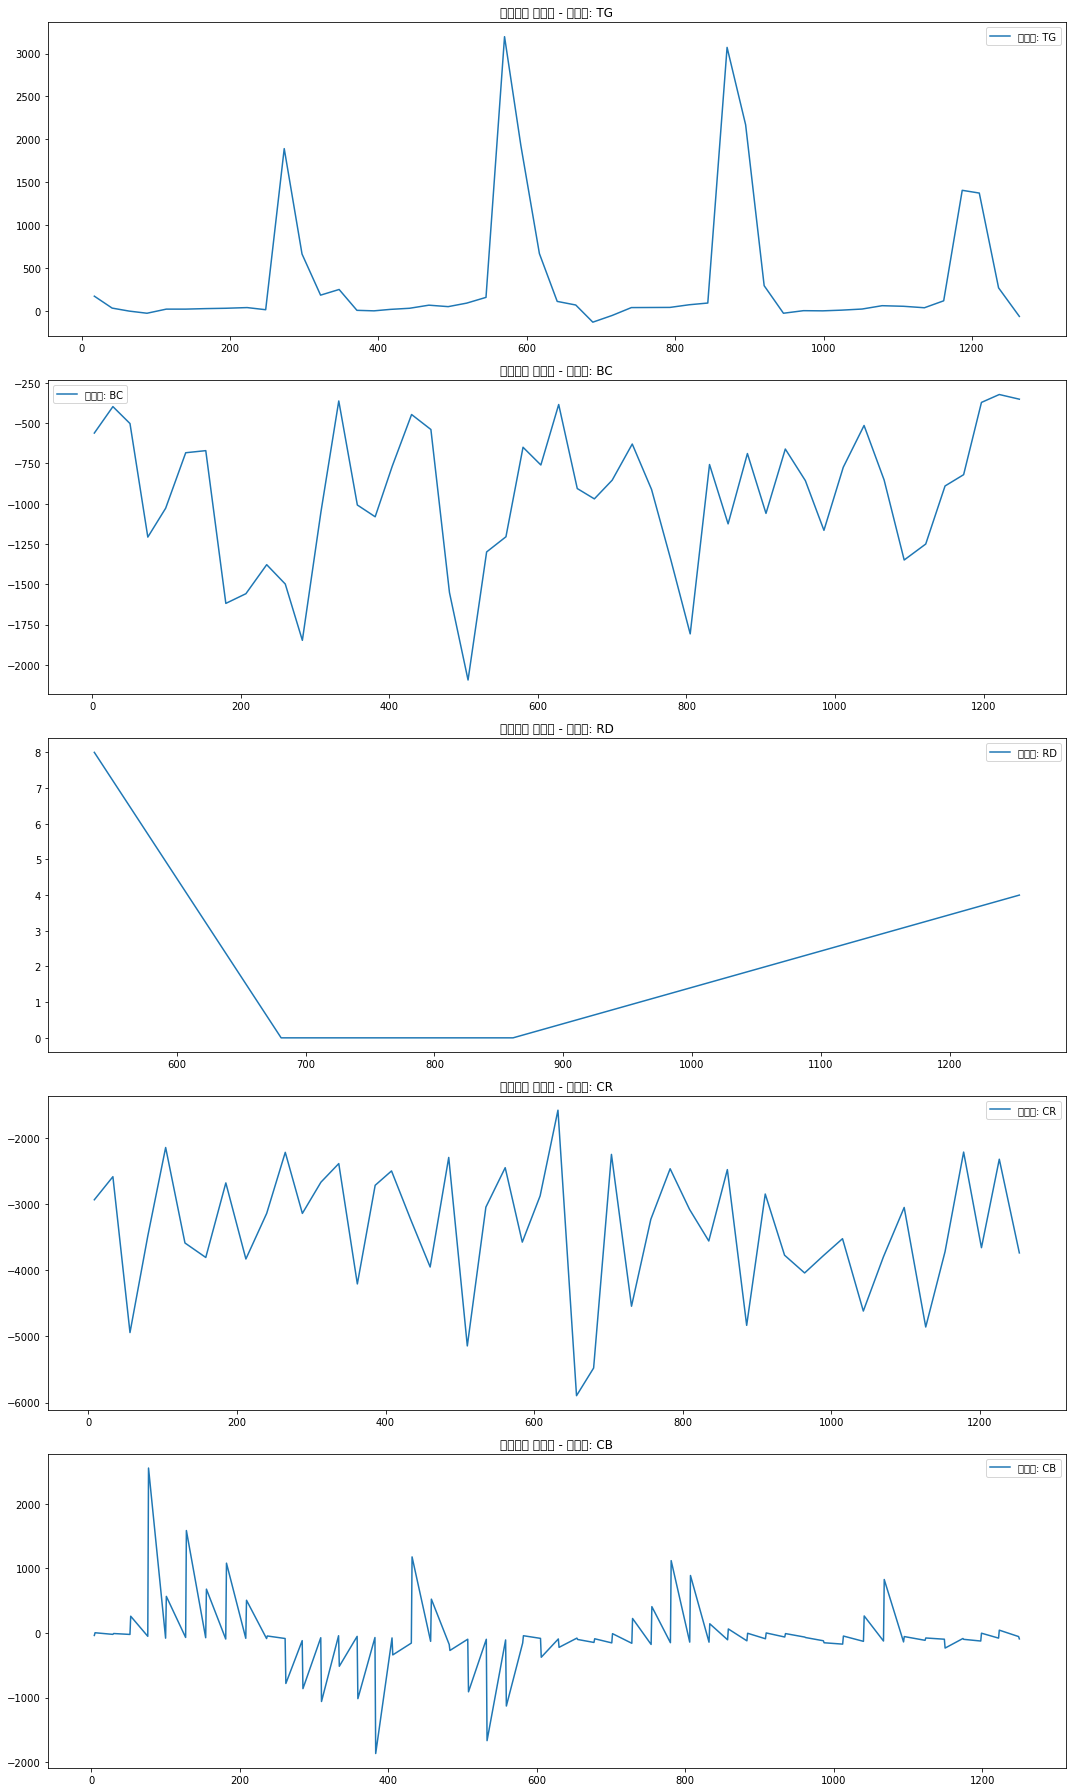

In [189]:
fig, axes = plt.subplots(5,1,figsize=(15,25))

# 각 품목에 대한 무역수지 그래프를 해당하는 서브플롯에 그리기
items = ['TG', 'BC', 'RD', 'CR', 'CB']

for i, item_type in enumerate(items):
    subset = df_test[df_test['품목명'] == item_type]['무역수지']
    axes[i].plot(subset, label=f'품목명: {item_type}')
    axes[i].set_title(f'무역수지 그래프 - 품목명: {item_type}')
    axes[i].legend()

# 그래프 간 간격 조정
plt.tight_layout()

# 그래프 표시
plt.show()

##### 무역수지가 무엇인고.. 하니 외국에 상품을 팔아서(수출) 번 돈과 외국의 물건을 구매(수입)하기 위해 사용한 돈의 차이..
##### 흑자면 수출>수입, 적자면 수입>수출

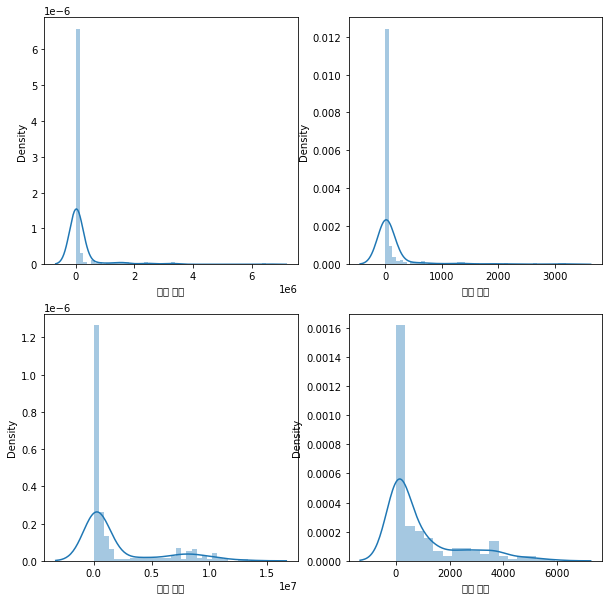

In [193]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
for i in range(len(box_plot_cols)):
    n=int(i/2)
    r = i%2
    sns.distplot(df_test[box_plot_cols[i]],ax=axes[n][r])

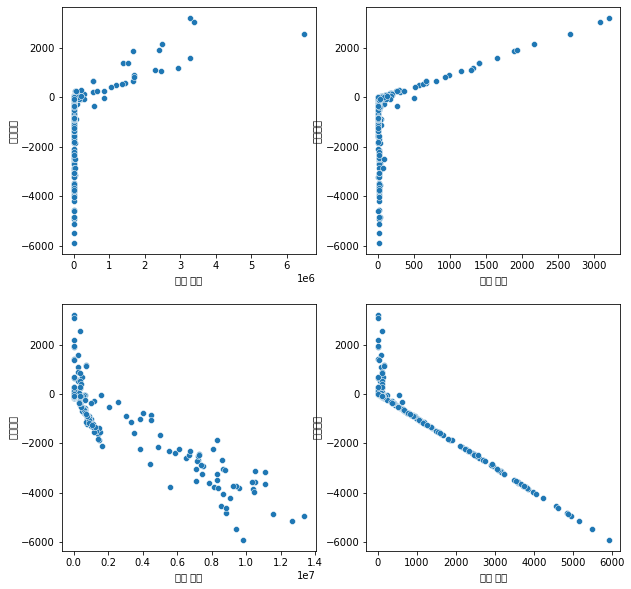

In [191]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
for i in range(len(box_plot_cols)):
    n=int(i/2)
    r = i%2
    sns.scatterplot(data=df_test,x=box_plot_cols[i],y='무역수지',ax=axes[n][r])

In [133]:
test.head()  #2023-03-04 ~ 2023-03-31 기간 가격 예측

,ID,timestamp,item,corporation,location
0,TG_A_J_20230304,2023-03-04,TG,A,J
1,TG_A_J_20230305,2023-03-05,TG,A,J
2,TG_A_J_20230306,2023-03-06,TG,A,J
3,TG_A_J_20230307,2023-03-07,TG,A,J
4,TG_A_J_20230308,2023-03-08,TG,A,J


In [134]:
trade.head() #2019-01 ~ 2023-02 수출입 데이터

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38


In [20]:
trade.tail()

,기간,품목명,수출 중량,수출 금액,수입 중량,수입 금액,무역수지
1269,2023-02,포포(papaw)[파파야(papaya)],0,0,23830,71,-71
1270,2023-02,사과,135165,351,0,0,351
1271,2023-02,배,2206012,5411,1,0,5411
1272,2023-02,신 체리[프루너스 체라서스(Prunus cerasus)],5,0,0,0,0
1273,2023-02,자두,0,0,2,0,0


## 전체 train 데이터에서 실제 학습기간 및 품목 설정

In [41]:
# 연-월 혹은 연-월-일 설정
start_date_train = '2019-01-01'
train_selected = train[train['timestamp'] >= start_date_train].copy().reset_index(drop=True)

#  품목 선택
item_selected = 'CB' #양배추 선택

## Feature engineering

### (1) 날짜 관련 feature 추가

In [33]:
# 날짜 관련 feature 추가 하기

train_selected['month'] = train_selected['timestamp'].dt.month
train_selected['week'] = train_selected['timestamp'].dt.isocalendar().week.astype(np.int32)
train_selected['weekday']  = train_selected['timestamp'].dt.weekday

# 날짜 관련 피처를 저장해 둔다.
features_date = ['month', 'week', 'weekday']

display(train_selected.columns)

Index(['ID', 'timestamp', 'item', 'corporation', 'location', 'supply(kg)',
       'price(원/kg)', 'month', 'week', 'weekday'],
      dtype='object')

,ID,timestamp,item,corporation,location,supply,price
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0
...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0


### (2) 7일 차분 가격중 자기 상관성 높은 데이터 피처로 생성


In [45]:
# 양배추 선택
cabbage = train[train['item'] == 'CB']\

# 날짜 기준 정렬
cabbage['timestamp'] = pd.to_datetime(cabbage['timestamp'])
cabbage = cabbage.sort_values('timestamp')

# 7일 차분 적용
cabbage['price_diff_7'] = cabbage['price'].diff(7)

# 결과 확인
print(cabbage[['timestamp', 'price', 'price_diff_7']])

       timestamp  price  price_diff_7
25891 2019-01-01    0.0           NaN
27414 2019-01-01    0.0           NaN
28937 2019-01-01    0.0           NaN
30460 2019-01-01    0.0           NaN
56351 2019-01-01    0.0           NaN
...          ...    ...           ...
28936 2023-03-03  848.0          50.0
30459 2023-03-03  780.0         780.0
31982 2023-03-03    0.0        -653.0
27413 2023-03-03    0.0        -858.0
57873 2023-03-03  643.0         643.0

[7615 rows x 3 columns]


C:\Users\eunse\AppData\Local\Temp\ipykernel_12412\3023075513.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cabbage['timestamp'] = pd.to_datetime(cabbage['timestamp'])


C:\Users\eunse\anaconda3\lib\site-packages\matplotlib\axes\_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)
C:\Users\eunse\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


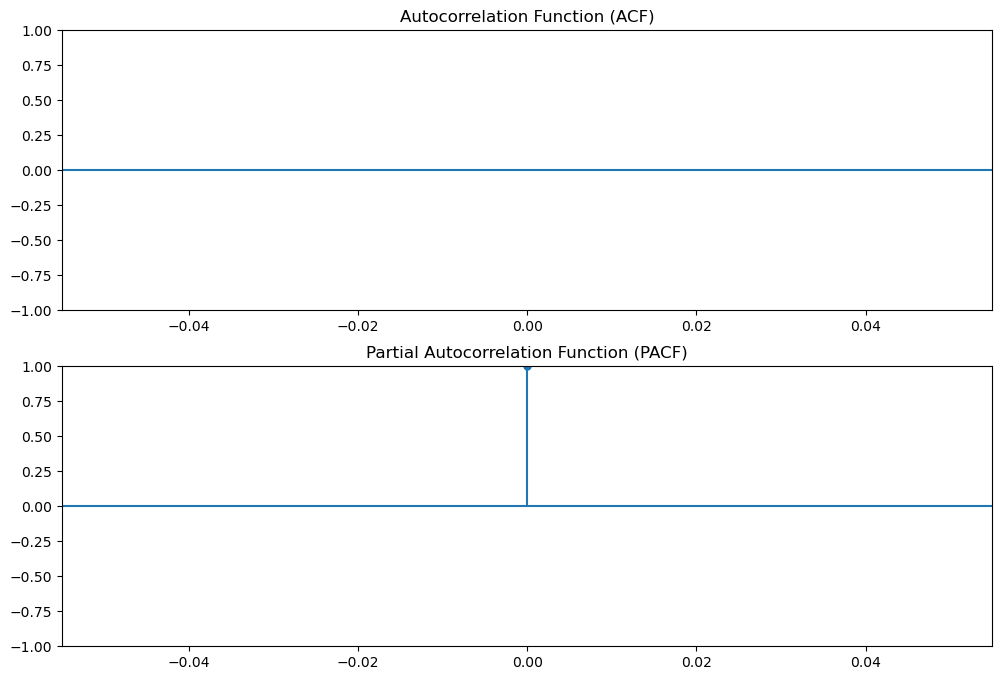

In [46]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF와 PACF 그래프 그리기
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# ACF 그래프
plot_acf(cabbage['price_diff_7'], lags=30, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# PACF 그래프
plot_pacf(cabbage['price_diff_7'], lags=30, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.show()

In [39]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 7일 차분을 적용한 데이터를 생성
train_price_diff = train_selected[['timestamp', f'{item_selected}_가격']].copy().diff(7).dropna()
train_price_diff.set_index('timestamp', inplace = True)

fig, ax = plt.subplots(1,2 ,figsize = (12, 4))

# ACF (AutoCorrelation Function) 그래프 그리기
plot_acf(train_price_diff[f'{item_selected}_가격'], lags=100, title=f'ACF ({item_selected}_가격)_차분', ax=ax[0])

# PACF (Partial AutoCorrelation Function) 그래프 그리기
plot_pacf(train_price_diff[f'{item_selected}_가격'], lags=100, title=f'PACF ({item_selected}_가격_차분)', ax=ax[1])

plt.tight_layout()
plt.show()

KeyError: "['CB_price'] not in index"